### Input data

Dataset from the Lammin Suo peatland station (Saint Petersburg, Russia) is available at Zenodo repository: https://doi.org/10.5281/zenodo.5060038

### Input and output directories:

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import os.path
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.dates as mdates
from pandas.tseries.offsets import MonthEnd

pd.options.mode.chained_assignment = None  # default='warn'

work_dir = os.path.join(globals()['_dh'][0], "data")

# fig_dir = os.path.dirname(os.path.realpath(__file__))  # __file__ is undefined in Jupyter Notebook
fig_dir = os.path.join(globals()['_dh'][0], "fig")
# print(fig_dir)

### Some helper functions:

In [2]:
def prepare(f, v=False):
    df = pd.read_csv(f, comment='#')
    try:
        datetimes = pd.to_datetime(df["DATE_TIME"])
    except KeyError:
        df.rename(columns={"START_DATE": "DATE_TIME"}, inplace=True)
        datetimes = pd.to_datetime(df["DATE_TIME"])
    df["DATE_TIME"] = datetimes
    df.set_index("DATE_TIME", inplace=True)
    if v:
        df.info()
    return df


def calc_intra_annual(df, mean_col, min_col=None, max_col=None, v=False):
    df["DAY"] = df.index.dayofyear
    # next we need to eliminate Feb 29th: 
    df["DAY"] = np.where(df.index.is_leap_year & (df.index.month > 2), df["DAY"] - 1, df["DAY"])  # we just ignore the existence of 29th Feb
    # display(df.loc[(df["DAY"] > 59) & (df["DAY"] <= 61)])
    
    params = ["mean", "std"]
    col_dict = {mean_col: params}
    if min_col is None:
        params.append("min")
    else:
        col_dict[min_col] = "min"
    if max_col is None:
        params.append("max")
    else:
        col_dict[max_col] = "max"
    
    out_df = df.groupby("DAY").agg(col_dict)
    out_df.columns = ("mean", "std", "min", "max")  # "flattens" grouped columns

    out_df["upper"] = out_df["mean"] + out_df["std"]
    out_df["lower"] = out_df["mean"] - out_df["std"]
    
    # checking if the upper and lower values are within max-min limits:
    out_df["upper"] = np.where(out_df["upper"] > out_df["max"], out_df["max"], out_df["upper"])
    out_df["lower"] = np.where(out_df["lower"] < out_df["min"], out_df["min"], out_df["lower"])
    if v:
        display(out_df)
    return out_df


def plot_intra_annual(df, ax):
    ax.fill_between(df.index, df["upper"], df["lower"], color="lightgrey", label="±SD")
    ax.plot(df.index, df["max"], color="grey", linewidth=1)
    ax.plot(df.index, df["min"], color="grey", linewidth=1, label="max/min")
    ax.plot(df.index, df["mean"], color="k", linewidth=1, label="mean")

    
def mark_axes(ax_tuple, px=-0.1, py=1.15):
    letter = "a"
    for ax in ax_tuple:
        ax.text(px, py, "(%s)" % letter, transform=ax.transAxes, fontsize=MEDIUM_SIZE, va='top', ha='right')
        letter = chr(ord(letter) + 1)  # increments the letter in alphabetical order

        
def monthly_ticks(ax, crop=False):
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_minor_locator(mdates.MonthLocator(bymonthday=16))  # 16 is a slight approximation since months differ in number of days

    ax.xaxis.set_major_formatter(matplotlib.ticker.NullFormatter())
    ax.xaxis.set_minor_formatter(mdates.DateFormatter('%b'))

    for tick in ax.xaxis.get_minor_ticks():
        tick.tick1line.set_markersize(0)
        tick.tick2line.set_markersize(0)
        tick.label1.set_horizontalalignment("center")
    ax.xaxis.get_minor_ticks()[-1].set_visible(False)
    if crop:
        ax.xaxis.get_minor_ticks()[0].set_visible(False)

### General font and fig size settings:

In [3]:
cm = 1 / 2.54  # inches to cm
wu = 8.5*cm  # width unit
hu = 6*cm  # height unit

LEAST_SIZE = 7
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

matplotlib.rc('font', size=SMALL_SIZE)          # controls default text sizes
matplotlib.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
matplotlib.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
matplotlib.rc('xtick', labelsize=LEAST_SIZE)    # fontsize of the tick labels
matplotlib.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
matplotlib.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
matplotlib.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

### Peat temperatures:

In [4]:
# in_file = "peat-temp_daily_1954-2020.csv"
in_file = "peat-temp_hourly_1976-2020.csv"

tmp = prepare(os.path.join(work_dir, in_file))
tmp = tmp.loc[tmp.index.year > 1976]
tmp = tmp.loc[tmp["SITE"] == "PT1"]
tmp = tmp.loc[tmp.index.hour == 15]

# display(tmp)
# tmp.info()

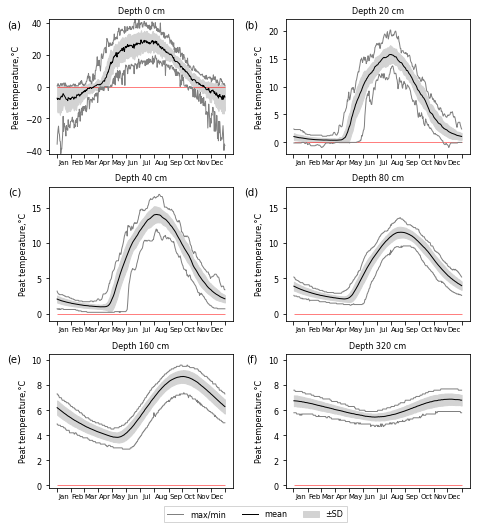

In [5]:
fig, ax = plt.subplots(3, 2)
fig.set_size_inches(2*wu, 3*hu)
ax = ax.flatten()

i = 0
depths = (0, 20, 40, 80, 160, 320)
limits = ((-42, 42), (-2, 22), (-1, 18), (-1, 18), (-0.2, 10.5), (-0.2, 10.5))
for depth, lim in zip(depths, limits):
    df = tmp.loc[tmp["DEPTH"] == depth]
    # display(df)

    df = calc_intra_annual(df, "PEAT_TEMP")
    # display(df)
    plot_intra_annual(df, ax[i])

    ax[i].hlines(y=0, xmin=1, xmax=365, linewidth=0.5, color='r')
    ax[i].yaxis.get_major_locator().set_params(integer=True)  # gets rid of ugly decimals
    ax[i].set_ylim(lim)
    monthly_ticks(ax[i], crop=True)
    ax[i].set_ylabel("Peat temperature,°C")
    ax[i].set_title("Depth %s cm" % depth)

    i += 1

   
mark_axes(ax, py=1.0, px=-0.15)
fig.tight_layout()
ax[0].legend(loc='upper center', bbox_to_anchor=(1.12, -2.60),fancybox=False, shadow=False, ncol=3) 
    
fig_path = os.path.join(fig_dir, "fig_09.png")
plt.savefig(fig_path, dpi=300, transparent=False, facecolor="white")

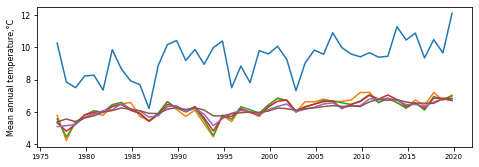

In [6]:
fig, ax = plt.subplots()
fig.set_size_inches(2*wu, 1*hu)

i = 0
depths = (0, 20, 40, 80, 160, 320)
for depth in depths:
    df = tmp.loc[tmp["DEPTH"] == depth]
    df = df.resample("AS-NOV").mean()
    df = df.iloc[:-1]
    # display(df)

    ax.plot(df.index, df["PEAT_TEMP"])

    ax.yaxis.get_major_locator().set_params(integer=True)  # gets rid of ugly decimals
    ax.set_ylabel("Mean annual temperature,°C")

    i += 1

fig.tight_layout()
    
fig_path = os.path.join(fig_dir, "peat_temp_trend.png")
plt.savefig(fig_path, dpi=300, transparent=False, facecolor="white")